In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functions import *


## SV Distribution Amongst Genetic Ancestry

In [2]:
haplotype_df = pd.read_parquet('/home/jupyter-yusuf/Consensus/output/3_haplotypes.parquet')

In [3]:
haplotype_df['SV'] = np.where(haplotype_df['haplotype'].str.contains('x') |
                      haplotype_df['haplotype'].str.contains('\+') |
                      haplotype_df['haplotype'].str.contains(r'\*5(?!\d+)'),
                      'SV',
                       'No SV')



In [4]:
data = pd.melt(haplotype_df, id_vars=['haplotype', 'activity_value', 'function', 'AF','SV'], value_vars=['AF_GA_C', 'AF_GA_I', 'AF_GA_M'], var_name='genetic_ancestry', value_name='percentage')
data = data.replace({'AF_GA_C': 'Chinese', 'AF_GA_I': 'Indian', 'AF_GA_M': 'Malay'})

In [5]:
data['function_status'] = data['function'].str.extract(r'(Normal|Decreased|No|Increased|Uncertain)')
data['haplotype'] = data['haplotype'] + " (" + data['function_status'] + ")"
data['genetic_ancestry'] = data['genetic_ancestry'].apply(calculate_sample, df = haplotype_df)
data['haplotype'] = data['haplotype'].replace("*10+*36 (Decreased)", "*36+*10 (Decreased)")

In [6]:
ancestry_color_map = {
    f'Chinese (N={int(haplotype_df["AC_C"].sum())})': '#8f001D',  
    f'Malay (N={int(haplotype_df["AC_M"].sum())})': '#107b01',    
    f'Indian (N={int(haplotype_df["AC_I"].sum())})': '#7e00ff'    
}
order_list_ga = [f'Chinese (N={int(haplotype_df["AC_C"].sum())})', f'Malay (N={int(haplotype_df["AC_M"].sum())})', f'Indian (N={int(haplotype_df["AC_I"].sum())})']
data['genetic_ancestry'] = pd.Categorical(data['genetic_ancestry'], categories=order_list_ga, ordered=True)



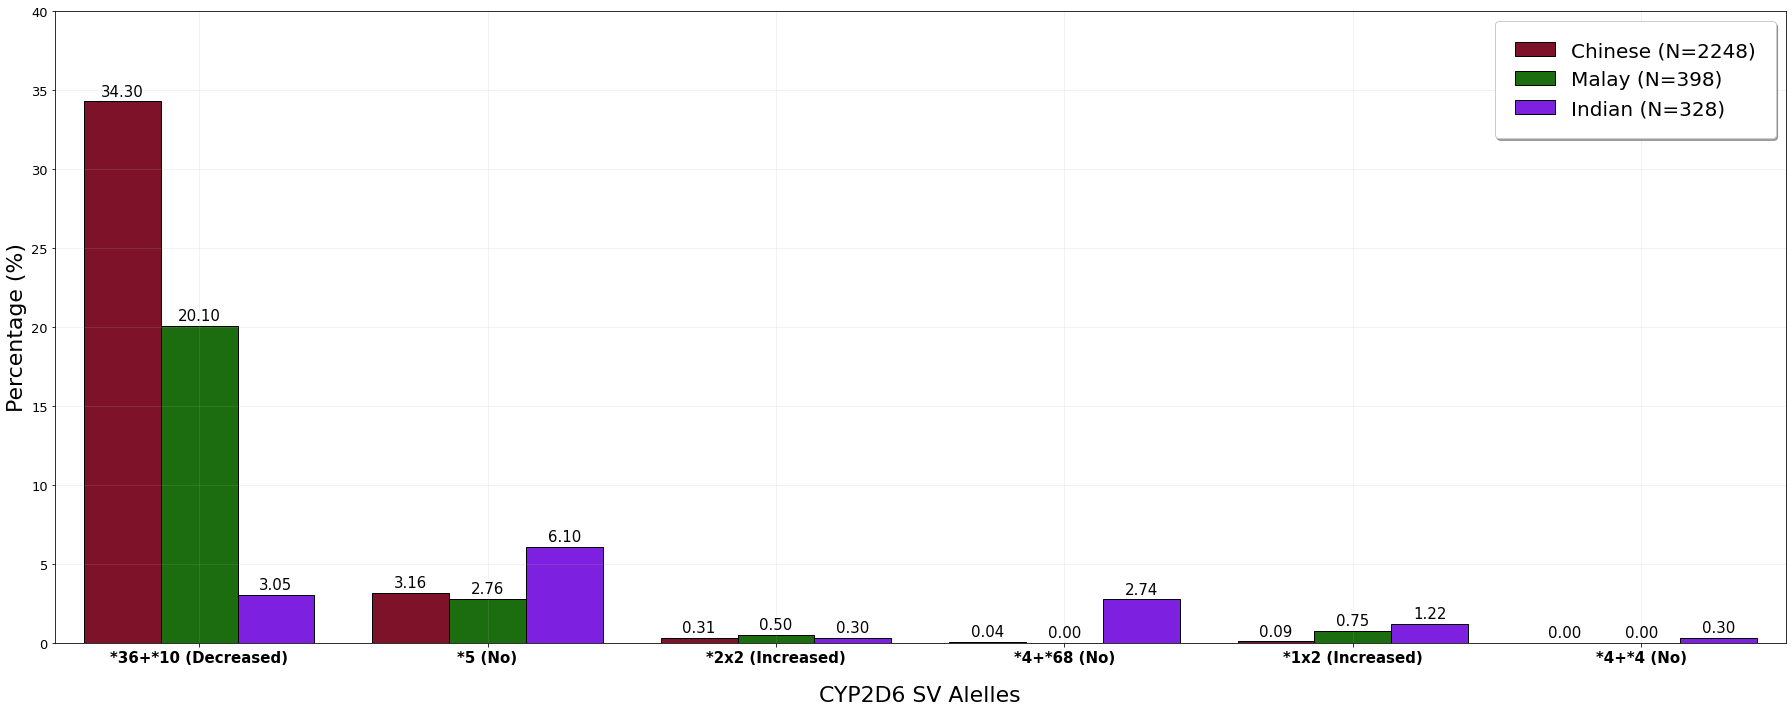

In [7]:
barplot_frequency(data.query("SV == 'SV'"),
                  x_col='haplotype', y_col='percentage', 
                  xlabel='CYP2D6 SV Alelles', ylabel='Percentage (%)', 
                  title=None, 
                  figsize=(25, 10), fontsize=15, label_fontsize=22,
                  x_ticks_rotation=False, ylim=40, hue='genetic_ancestry', palette=ancestry_color_map, legend="Genetic Ancestry",
                  colored_xticks=False, grid = True)

# Phenotype distribution based on SV status

In [8]:
diplotype_df = pd.read_parquet('/home/jupyter-yusuf/Consensus/output/3_diplotypes.parquet')

In [9]:

diplotype_df['cnv'] = np.where(diplotype_df['diplotype'].str.contains('x') |
                      diplotype_df['diplotype'].str.contains('\+') |
                      diplotype_df['diplotype'].str.contains(r'\*5(?!\d+)'),
                      f'SV',
                       'No SV')

diplotype_df.groupby(diplotype_df['cnv'])['AC'].sum()

cnv
No SV    660
SV       827
Name: AC, dtype: int64

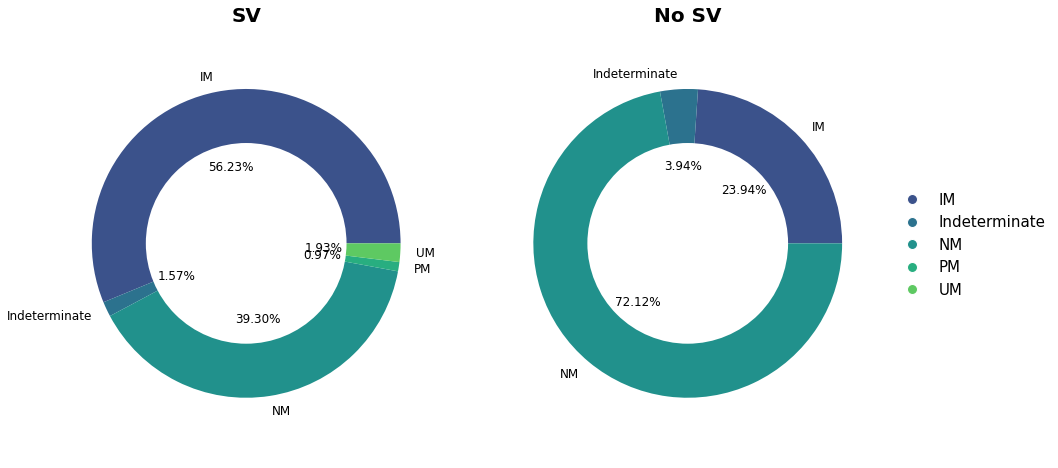

In [10]:
# Get unique labels from the 'phenotype' column in diplotype_df
unique_labels = np.unique(diplotype_df['phenotype'])
colors = ['#3b528b', '#2c728e', '#21918c', '#28ae80', '#5ec962']


# Create a color palette and a dictionary to map labels to colors
label_color_map = dict(zip(sorted(unique_labels), colors))

# Create subplots
fig, axes = plt.subplots(1,2, figsize=(14, 8))
cnv_df = diplotype_df[diplotype_df['cnv'] == f"SV"].groupby('phenotype')['AC'].sum()
sc_df = diplotype_df[diplotype_df['cnv'] == "No SV"].groupby('phenotype')['AC'].sum()

donut_chart(axes[0], data=cnv_df, title=f"SV", title_fontsize=20, startangle=0, label_color_map=label_color_map)
donut_chart(axes[1], data=sc_df, title="No SV", title_fontsize=20, startangle=0, label_color_map=label_color_map)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                   for label, color in label_color_map.items()]
fig.legend(handles=legend_elements, loc='right', fontsize=15, frameon=False, bbox_to_anchor=(1.1, 0.5))

# Adjust distance between plots
plt.subplots_adjust(wspace=0.3)

plt.show()


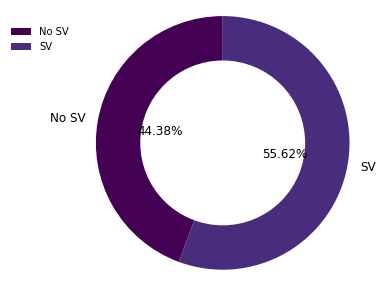

In [11]:
# Donut chart of CNV Haplotypes proportion in the dataset
colors = ["#440154", "#472d7b"]
fig, ax = plt.subplots(figsize = (5, 5))
donut_chart(ax, data= diplotype_df.groupby('cnv')['AC'].sum(), title = None, title_fontsize = 14, startangle = 90, label_color_map = colors)
fig.legend(loc='upper left', bbox_to_anchor=(-0.1, 0.85), fontsize=10, frameon=False)

# Adding CN column 
Number of cnv

methods:
- Counting the number of star alleles
- *5 equals to 0 CN
- *1x2 equals to 3 CN

In [32]:
def calculate_cn(diplotype):
    star_count = diplotype.count('*')
    five_count = diplotype.count('*5')
    x_count = diplotype.count('x')
    return star_count - five_count + x_count

In [33]:
diplotype_df['CN'] = diplotype_df['diplotype'].apply(calculate_cn)
diplotype_df.head()

,diplotype,AC,AF,AC_C,AF_C,AF_GA_C,AC_I,AF_I,AF_GA_I,AC_M,AF_M,AF_GA_M,activity_value,phenotype,cnv,CN
0,*1/*10+*36,248,16.500333,223.0,14.836993,19.595782,2.0,0.133067,1.212121,23.0,1.530273,11.5,1.25,NM,SV,3
1,*10+*36/*10+*36,164,10.911510,152.0,10.113107,13.356766,1.0,0.066534,0.606061,11.0,0.731870,5.5,0.50,IM,SV,4
2,*10/*10+*36,152,10.113107,132.0,8.782435,11.599297,1.0,0.066534,0.606061,19.0,1.264138,9.5,0.50,IM,SV,3
3,*1/*1,119,7.917498,76.0,5.056554,6.678383,23.0,1.530273,13.939394,20.0,1.330672,10.0,2.00,NM,No SV,2
4,*1/*10,111,7.385230,77.0,5.123087,6.766257,2.0,0.133067,1.212121,32.0,2.129075,16.0,1.25,NM,No SV,2


In [28]:
diplotype_df['AC'].sum()

1503

Text(0.5, 0, 'Copy Number')

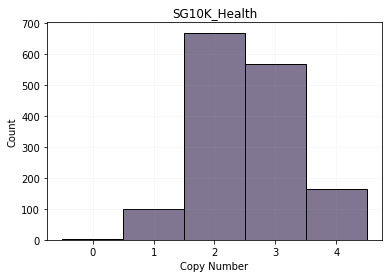

In [34]:
sns.histplot(diplotype_df[['CN', 'AC']], x='CN', weights='AC', bins=20, discrete=True, color='#55486D')
plt.title('SG10K_Health')
plt.grid(alpha=0.1)
plt.xlabel('Copy Number')

Text(0.5, 0, 'Copy Number')

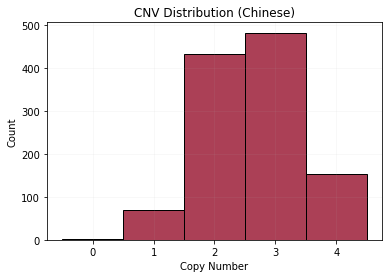

In [33]:
# Chinese
sns.histplot(diplotype_df[['CN', 'AC_C']], x='CN', weights='AC_C', bins=20, discrete=True, color='#8f001D')
plt.title('SG10K - Chinese')
plt.grid(alpha=0.1)
plt.xlabel('Copy Number')

Text(0.5, 0, 'Copy Number')

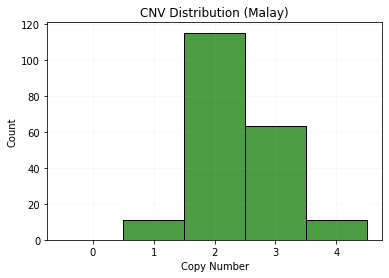

In [31]:
# Chinese
sns.histplot(diplotype_df[['CN', 'AC_M']], x='CN', weights='AC_M', bins=20, discrete=True, color='#107b01')
plt.title('SG10K - Malay')

plt.grid(alpha=0.1)
plt.xlabel('Copy Number')

Text(0.5, 0, 'Copy Number')

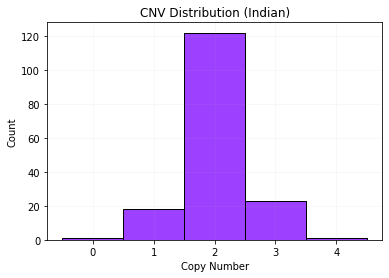

In [32]:
# Chinese
sns.histplot(diplotype_df[['CN', 'AC_I']], x='CN', weights='AC_I', bins=20, discrete=True, color='#7e00ff')
plt.title('SG10K - Indian')
plt.grid(alpha=0.1)
plt.xlabel('Copy Number')

Text(0.5, 0, 'Copy Number')

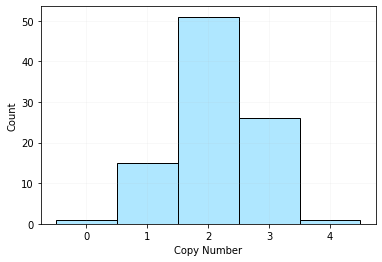

In [52]:
sns.histplot(diplotype_df['CN'].value_counts().reset_index(), x='index', weights='CN', bins=20, discrete=True, color='#94DFFF')
plt.grid(alpha=0.1)
plt.xlabel('Copy Number')

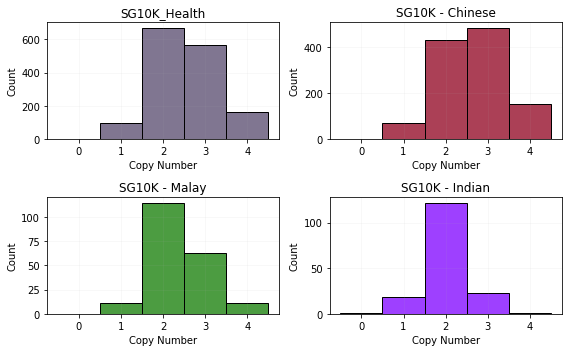

In [37]:
# Creating a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# First plot
sns.histplot(diplotype_df[['CN', 'AC']], x='CN', weights='AC', bins=20, discrete=True, color='#55486D', ax=axes[0, 0])
axes[0, 0].set_title('SG10K_Health')
axes[0, 0].grid(alpha=0.1)
axes[0, 0].set_xlabel('Copy Number')

# Second plot
sns.histplot(diplotype_df[['CN', 'AC_C']], x='CN', weights='AC_C', bins=20, discrete=True, color='#8f001D', ax=axes[0, 1])
axes[0, 1].set_title('SG10K - Chinese')
axes[0, 1].grid(alpha=0.1)
axes[0, 1].set_xlabel('Copy Number')

# Third plot
sns.histplot(diplotype_df[['CN', 'AC_M']], x='CN', weights='AC_M', bins=20, discrete=True, color='#107b01', ax=axes[1, 0])
axes[1, 0].set_title('SG10K - Malay')
axes[1, 0].grid(alpha=0.1)
axes[1, 0].set_xlabel('Copy Number')

# Fourth plot
sns.histplot(diplotype_df[['CN', 'AC_I']], x='CN', weights='AC_I', bins=20, discrete=True, color='#7e00ff', ax=axes[1, 1])
axes[1, 1].set_title('SG10K - Indian')
axes[1, 1].grid(alpha=0.1)
axes[1, 1].set_xlabel('Copy Number')

plt.tight_layout()
plt.show()